In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

In [2]:
# define plot function for later convenience
def plot_singlenode(model, duration, dt, state, target, control, input, weight_array=[], M=1):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    for m in range(M-1):
        model.run()
        state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
        ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
        ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

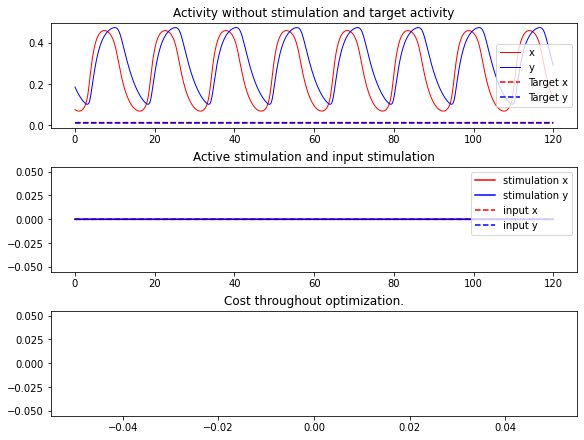

In [3]:
wc = WCModel()
wc.params.sigma_ou = 0.
wc.params.x_ou_mean = 0.

dt = wc.params["dt"]
duration = 120.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
background_input_osc = zero_input.copy()
background_input_osc += 2.

wc.params["duration"] = duration
wc.run()

x_init = np.array([[wc.exc[0,-1]]])
y_init = np.array([[wc.inh[0,-1]]])
wc.params["exc_init"] = x_init
wc.params["inh_init"] = y_init
wc.run()

target = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

wc.params["exc_ext"] = zero_input + background_input_osc
wc.params["inh_ext"] = zero_input
wc.run()

x_init_osc = np.array([[wc.exc[0,-1]]])
y_init_osc = np.array([[wc.inh[0,-1]]])
wc.params["exc_init"] = x_init_osc
wc.params["inh_init"] = y_init_osc
wc.run()

state = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

plot_singlenode(wc, duration, dt, state, target, zero_control, zero_control)

In [4]:
wc.params["exc_ext"] = zero_input + background_input_osc
wc.params["inh_ext"] = zero_input
w2 = 1e-2
wp = 1.
printarray = np.concatenate( (np.arange(0,101,1), np.arange(200,1001,100)) )
wc_controlled_noisefree = oc_wc.OcWc(wc, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=(1000,None))

# We run 100 iterations of the optimal control gradient descent algorithm
wc_controlled_noisefree.optimize(10)

state = wc_controlled_noisefree.get_xs()
control_noisefree = wc_controlled_noisefree.control

plot_singlenode(wc_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, wc_controlled_noisefree.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 20.79181391483383


/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'interval' of function 'derivative_precision_cost'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../neurolib/optimal_control/cost_functions.py", line 45:
@numba.njit
def derivative_precision_cost(x_target, x_sim, w_p, precision_matrix, interval=(0, None)):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


TypeError: can't unbox heterogeneous list: int64 != none

Compute control for a deterministic system
Cost in iteration 0: 0.6687210081606866
Cost in iteration 1: 0.668602068205939
Cost in iteration 2: 0.6685175570017536
Cost in iteration 3: 0.6683698373036536
Cost in iteration 4: 0.6683590968816049
Cost in iteration 5: 0.6681567900689399
Cost in iteration 6: 0.6680299814434751
Cost in iteration 7: 0.6679755822672565
Cost in iteration 8: 0.6678111700570257
Cost in iteration 9: 0.6676999848359068
Cost in iteration 10: 0.6676156657372293
Cost in iteration 11: 0.667478826173936
Cost in iteration 12: 0.6674599875558911
Cost in iteration 13: 0.6672747120096554
Cost in iteration 14: 0.6671571032180917
Cost in iteration 15: 0.6670986376010379
Cost in iteration 16: 0.6669479810466846
Cost in iteration 17: 0.6668445880892975
Cost in iteration 18: 0.6667592816069604
Cost in iteration 19: 0.6666335587956619
Cost in iteration 20: 0.6666051462673027
Cost in iteration 21: 0.666437424470412
Cost in iteration 22: 0.6663289990839222
Cost in iteration 23: 0.666

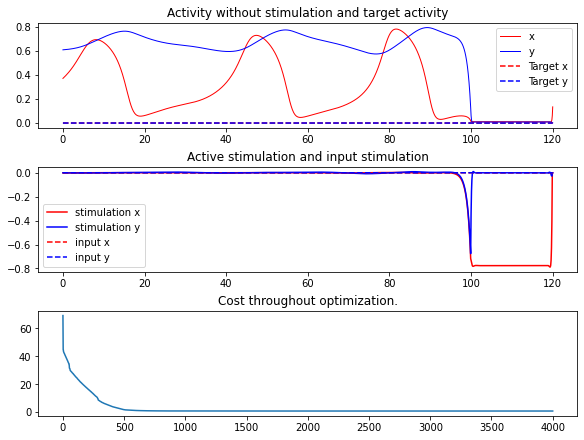

In [ ]:
wc_controlled_noisefree.optimize(3000)

state = wc_controlled_noisefree.get_xs()
control_noisefree = wc_controlled_noisefree.control

plot_singlenode(wc_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, wc_controlled_noisefree.cost_history)

In [ ]:
sigma_array = [2. * 1e-3, 1.* 1e-2]
M_array = [4,20,100]

weights = np.zeros(( len(sigma_array) ))
controls = [ [None, None, None], [None, None, None] ]
costs_history = [ [None, None, None], [None, None, None] ]
costs = np.zeros(( len(sigma_array), len(M_array)+1 ))

In [ ]:
wc_noise = wcModel()
wc_noise.params.sigma_ou = 0.
wc_noise.params.x_ou_mean = 0.

In [ ]:
wc_noise.params.duration = 1. * 1e6
wc_noise.params["exc_init"] = np.array([[x_init]])
wc_noise.params["inh_init"] = np.array([[y_init]])
wc_noise.params["exc_ext"] = zero_input
wc_noise.params["inh_ext"] = zero_input

for i_s in range(len(sigma_array)):
    wc_noise.params.sigma_ou = sigma_array[i_s]

    wc_noise.run()
    weights[i_s] = 1. / (np.std(wc_noise.x[0,100:]) + np.std(wc_noise.y[0,100:]) )

print(weights)

[22.97867797  3.97503799]


In [ ]:
wc_noise.params.duration = duration
wc_noise.params["exc_init"] = x_init_osc
wc_noise.params["inh_init"] = y_init_osc

wc_noise.params.x_ou_mean = 0.8
M_val = 500
max_iterations = 2000
wc_noise.run()
printarray = np.concatenate( (np.arange(0,100,10), np.arange(0,2001,100)) )

#costs_history = [ [None, None, None, None], [None, None, None, None], [None, None, None, None] ]

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):

        if i_m in []:
            continue

        if i_s in []:
            continue

        if type(costs_history[i_s][i_m]) != type(None):
            continue

        print("--------------------------------------------------------------")
        print("---------------------------- sigma, M = ", sigma_array[i_s], M_array[i_m])

        wc_noise.params["exc_ext"] = zero_input
        wc_noise.params["inh_ext"] = zero_input
        wc_noise.params.sigma_ou = sigma_array[i_s]

        wc_controlled_models = oc_wc.Ocwc(wc_noise, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=[1000,None],
                                    M=int(M_array[i_m]),
                                    #M = 10,
                                    M_validation=M_val, validate_per_step=True)

        wc_controlled_models.step = 0.01

        # We run 100 iterations of the optimal control gradient descent algorithm
        wc_controlled_models.optimize(max_iterations)

        state = wc_controlled_models.get_xs()
        controls[i_s][i_m] = wc_controlled_models.control
        costs_history[i_s][i_m] = wc_controlled_models.cost_history
        costs[i_s][i_m+1] = wc_controlled_models.cost_validation

        # plot_singlenode(wc_controlled_models.model, duration, dt, state, target, controls[i_s][i_m], zero_control, wc_controlled_models.cost_history, M=10)

In [ ]:
wc_plot = wcModel()
wc_plot.params.x_ou_mean = 0.8

wc_plot.params["duration"] = duration
wc_plot.params["exc_init"] = x_init_osc
wc_plot.params["inh_init"] = y_init_osc


In [ ]:
for i_s in range(len(sigma_array)):

    print(i_s)

    wc_plot.params.sigma_ou = sigma_array[i_s]

    wc_plot.params["exc_ext"] = control_noisefree[:,0,:]
    wc_plot.params["inh_ext"] = control_noisefree[:,1,:]

    cost_validation = 0.0
    energy_cost = cost_functions.energy_cost(control_noisefree, w_2=w2)

    for m in range(M_val):
        wc_plot.run()
        state = np.concatenate((np.concatenate( (wc_plot.params["exc_init"], wc_plot.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc_plot.x, wc_plot.y), axis=1)), axis=2)
        precision_cost = cost_functions.precision_cost(target, state, wp, 1, np.ones( (1, 2)), [1000,-1])
        cost_validation += precision_cost

    costs[i_s][0] =  energy_cost + cost_validation/M_val

print(costs[0][0], costs[1][0])

0
1
0.7299895558151007 3.756553063563364


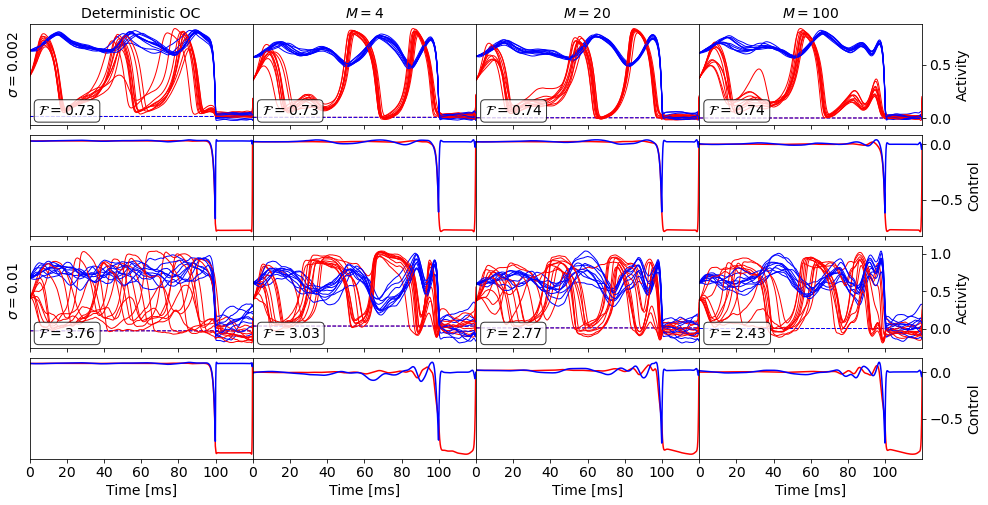

In [ ]:
row, col = int(2*len(sigma_array)), int(len(M_array)+1)

fig = plt.figure(figsize=(4*col,2*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fs = 14
savepath = '..' + os.sep + '..' + os.sep + '..' + os.sep + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + '2022_Wittenberg' + os.sep + 'talk' + os.sep + 'talk' + os.sep + 'images'

time_array = np.arange(0, duration+dt, dt)

for i_s in range(len(sigma_array)):
    ax[2*i_s, 0].text(-0.1, 0.3, r'$\sigma = $'+ "{}".format(sigma_array[i_s]),
    transform=ax[2*i_s, 0].transAxes, rotation='vertical', fontsize=fs)

    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,0,:], color=color_x)
    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,1,:], color=color_y)
    
    wc_plot.params.sigma_ou = sigma_array[i_s]

    wc_plot.params["exc_ext"] = control_noisefree[:,0,:]
    wc_plot.params["inh_ext"] = control_noisefree[:,1,:]

    ax[2*i_s, 0].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
    ax[2*i_s, 0].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

    for m in range(10):
        wc_plot.run()
        ax[2*i_s, 0].plot(time_array[1:], wc_plot.x[0,:], color=color_x, linewidth=1)
        ax[2*i_s, 0].plot(time_array[1:], wc_plot.y[0,:], color=color_y, linewidth=1)

    ax[2*i_s, 0].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][0]),
        transform=ax[2*i_s, 0].transAxes, fontsize=fs, bbox=box_props)

    for i_m in range(len(M_array)):
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,0,:], color=color_x)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,1,:], color=color_y)

        ax[2*i_s, i_m+1].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][i_m+1]),
        transform=ax[2*i_s, i_m+1].transAxes, fontsize=fs, bbox=box_props)

        wc_plot.params["exc_ext"] = controls[i_s][i_m][:,0,:]
        wc_plot.params["inh_ext"] = controls[i_s][i_m][:,1,:]

        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

        for m in range(10):
            wc_plot.run()
            ax[2*i_s, i_m+1].plot(time_array[1:], wc_plot.x[0,:], color=color_x, linewidth=1)
            ax[2*i_s, i_m+1].plot(time_array[1:], wc_plot.y[0,:], color=color_y, linewidth=1)



    for k in range(col-1):
        ax[2*i_s,k].set_yticks([])
        ax[2*i_s+1,k].set_yticks([])
    
    ax[2*i_s,-1].yaxis.tick_right()
    ax[2*i_s+1,-1].yaxis.tick_right()

    ax[2*i_s,-1].set_ylabel("Activity", fontsize=fs)
    ax[2*i_s,-1].yaxis.set_label_position("right")
    ax[2*i_s+1,-1].set_ylabel("Control", fontsize=fs)
    ax[2*i_s+1,-1].yaxis.set_label_position("right")


for k in range(col):
    for j in range(row-1):
        ax[j,k].set_xticks([])
        ax[j,k].set_xlim([0,duration])
        ax[j,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xticks(np.arange(0,120,20))
    ax[-1,k].set_xlim([0,duration])
    ax[-1,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xlabel("Time [ms]", fontsize=fs)

for i_m in range(len(M_array)):
    ax[0,i_m+1].set_title(r"$M=$" + "{}".format(M_array[i_m]), fontsize=fs)

ax[0,0].set_title(r"Deterministic OC", fontsize=fs)

fig.savefig(os.path.join(savepath, 'wc_osc_down_traces.jpg'), bbox_inches='tight')
plt.show()


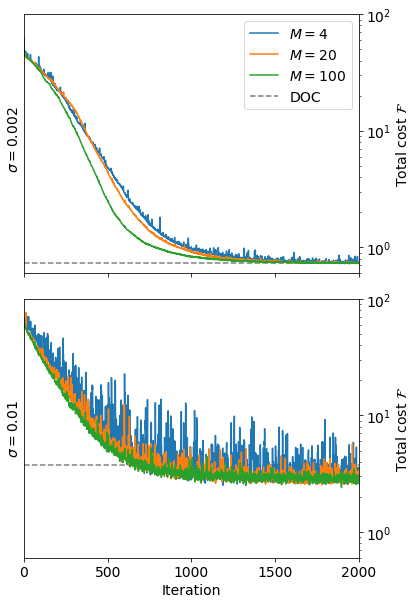

In [ ]:
row, col = len(sigma_array), 1

fig = plt.figure(figsize=(6,5*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
fs = 14

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):
        ax[i_s].plot(costs_history[i_s][i_m], label=r'$M=$' + '{}'.format(M_array[i_m]))

    ax[i_s].hlines(costs[i_s,0], 0, max_iterations, label='DOC', linestyle='--', color='grey')

    ax[i_s].text(-0.05, 0.4, r'$\sigma = $'+ "{}".format(sigma_array[i_s]), transform=ax[i_s].transAxes, rotation='vertical', fontsize=fs)

    ax[i_s].set_ylabel(r'Total cost $\mathcal{F}$', fontsize=fs)
    ax[i_s].yaxis.set_label_position("right")
    ax[i_s].yaxis.tick_right()
    ax[i_s].tick_params(axis='both', labelsize=fs)
    ax[i_s].set_xlim([0,max_iterations])
    ax[i_s].set_yscale('log')
    ax[i_s].set_ylim(0.6, 100)

ax[0].legend(loc='upper right', fontsize=fs)
ax[-1].set_xlabel("Iteration", fontsize=fs)


fig.savefig(os.path.join(savepath, 'wc_osc_down_cost.jpg'), bbox_inches='tight')
plt.show()